Run the cell below to unzip the processed data for the binary model. Then you'll have it on the local drive, so it should be quicker to access

In [ ]:
import shutil
import os
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Define Paths
# Where the zip lives on your Google Drive
ZIP_SOURCE = "/content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/train/processed_data/processed_dataset_damage.zip"

# Where to extract it (Local Colab Disk)
EXTRACT_DEST = "/content/dataset"

# 3. Copy & Unzip (The Fast Way)
if not os.path.exists(EXTRACT_DEST):
    # print("Copying zip from Drive...")
    # shutil.copy(ZIP_SOURCE, "/content/temp_data.zip")

    print("Unzipping...")
    shutil.unpack_archive(ZIP_SOURCE, EXTRACT_DEST)

    # Cleanup to save space
    print(f"Data ready at {EXTRACT_DEST}")
else:
    print("Data already extracted!")

Mounted at /content/drive
Unzipping...
Data ready at /content/dataset


1. What the Data Looks Like
* Images (/images):
  * Content: 512x512 pixel chips cropped from the original (1024x1024) satellite photos.
  * Format: Standard RGB PNG files.
  * Source: Includes both Pre-disaster and Post-disaster images (effectively doubling your training data for localization).
* Masks (/masks):
  * to be used as target
  * Content: 512x512 pixel chips matching the images exactly.
  * Format: Grayscale PNG files.
  * Values:
    * 0 (Black): Background (trees, roads, water, etc.).
    * 1 (Dark Gray/Black): Building.
    * Note: Since the value is 1, it will look completely black if you open it in a standard image viewer. computer should still be able to read it.

In [ ]:
import os
from glob import glob

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models

from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [ ]:
class DamageBuildingDataset(Dataset):
    def __init__(self, root_dir, transform=None):

        self.root_dir = root_dir
        self.img_dir = os.path.join(root_dir, "images_post")
        self.mask_dir = os.path.join(root_dir, "masks")
        self.transform = transform

        # collect all image paths
        self.img_paths = sorted(glob(os.path.join(self.img_dir, "*.png")))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        filename = os.path.basename(img_path)
        mask_path = os.path.join(self.mask_dir, filename)

        # load image
        img = Image.open(img_path).convert("RGB")

        # load mask as grayscale (0/1 or 0/255)
        mask = Image.open(mask_path).convert("L")
        mask_np = np.array(mask)

        # label = 1 if any building pixel exists, else 0
        max_damage = np.max(mask_np)
        label = torch.tensor(max_damage, dtype=torch.float32)

        if self.transform:
            img = self.transform(img)

        return img, label


In [ ]:
PROCESSED_DIR = "/content/dataset"

img_size = 256
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

full_dataset = DamageBuildingDataset(PROCESSED_DIR, transform=transform)

len(full_dataset)


25191

In [ ]:
# Checking for class imbalance
labels = []
for i in range(min(2000, len(full_dataset))):
    _, y = full_dataset[i]
    labels.append(int(y.item()))

unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

# results: class 0 (no buildings) 788, class 1 (buildings) 1212, so class imbalance isn't too bad

{np.int64(0): np.int64(764),
 np.int64(1): np.int64(680),
 np.int64(2): np.int64(60),
 np.int64(3): np.int64(252),
 np.int64(4): np.int64(20),
 np.int64(5): np.int64(224)}

In [ ]:
val_frac = 0.2
val_size = int(len(full_dataset) * val_frac)
train_size = len(full_dataset) - val_size

train_ds, val_ds = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42),
)

batch_size = 32

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

len(train_ds), len(val_ds)


(20153, 5038)

In [ ]:
class BuildingDamageResNet(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        in_features = base.fc.in_features
        base.fc = nn.Identity()
        self.backbone = base
        self.fc = nn.Linear(in_features, 6)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        feats = self.backbone(x)
        logit = self.fc(feats)  # (B, 6)
        softmax = self.softmax(logit)
        return softmax

model = BuildingDamageResNet().to(device)
model


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]


BuildingDamageResNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs = imgs.to(device)
        labels = labels.to(device).long() # Ensure labels are long type for CrossEntropyLoss

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)

        # predictions: for multiclass, use argmax
        preds = torch.argmax(logits, dim=1) # Multiclass prediction
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

@torch.no_grad()
def eval_epoch(model, loader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in tqdm(loader, desc="Val", leave=False):
        imgs = imgs.to(device)
        labels = labels.to(device).long() # Ensure labels are long type for CrossEntropyLoss

        logits = model(imgs)
        loss = criterion(logits, labels)

        running_loss += loss.item() * labels.size(0)

        preds = torch.argmax(logits, dim=1) # Multiclass prediction
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


In [ ]:
num_epochs = 5
best_val_acc = 0.0

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc = eval_epoch(model, val_loader, device)

    print(f"  Train loss: {train_loss:.4f}  acc: {train_acc:.4f}")
    print(f"  Val   loss: {val_loss:.4f}  acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "building_damage_resnet18.pth")
        print("Saved new best model")



Epoch 1/5


Train:   0%|          | 0/630 [00:00<?, ?it/s]

Val:   0%|          | 0/158 [00:00<?, ?it/s]

  Train loss: 1.2867  acc: 0.7574
  Val   loss: 1.3105  acc: 0.7301
Saved new best model

Epoch 2/5


Train:   0%|          | 0/630 [00:00<?, ?it/s]

Val:   0%|          | 0/158 [00:00<?, ?it/s]

  Train loss: 1.2620  acc: 0.7836
  Val   loss: 1.3054  acc: 0.7364
Saved new best model

Epoch 3/5


Train:   0%|          | 0/630 [00:00<?, ?it/s]

Val:   0%|          | 0/158 [00:00<?, ?it/s]

  Train loss: 1.2404  acc: 0.8047
  Val   loss: 1.2920  acc: 0.7485
Saved new best model

Epoch 4/5


Train:   0%|          | 0/630 [00:00<?, ?it/s]

Val:   0%|          | 0/158 [00:00<?, ?it/s]

  Train loss: 1.2199  acc: 0.8246
  Val   loss: 1.3078  acc: 0.7356

Epoch 5/5


Train:   0%|          | 0/630 [00:00<?, ?it/s]

Val:   0%|          | 0/158 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9a088762a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d9a088762a0>
    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

     self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        if w.is_alive():^
^ ^ ^ ^ ^ ^ ^ ^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^ 
   File "/usr/lib/p

  Train loss: 1.2014  acc: 0.8429
  Val   loss: 1.2824  acc: 0.7598
Saved new best model


In [ ]:
import torch

model = BuildingDamageResNet().to(device)
model.load_state_dict(torch.load("building_damage_resnet18.pth", map_location=device))
model.eval()

from PIL import Image
import torch.nn.functional as F

@torch.no_grad()
def predict_tile(img_path, threshold=0.5):
    """
    Run the binary model on a single tile image.
    Returns (pred_label, prob).
    """
    model.eval()
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)

    logit = model(x)
    pred = torch.argmax(logits, dim=1) # Multiclass prediction
    prob = torch.max(logits, dim = 1)

    print(f"Tile: {img_path}")
    print(f"Building presence probability: {prob:.3f}")
    print(f"Predicted class: {pred} (1 = has buildings, 0 = no buildings)")

    return pred, prob


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.eval()

val_labels = []
val_probs = []
val_preds = []

for imgs, labels in val_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        logits = model(imgs)
        preds = torch.argmax(logits, dim=1)

    val_labels.extend(labels.cpu().numpy().tolist())
    val_preds.extend((preds).cpu().numpy().tolist())

val_labels = np.array(val_labels, dtype=int)
val_preds = np.array(val_preds, dtype=int)

print("Confusion matrix (rows=true, cols=pred):")
print(confusion_matrix(val_labels, val_preds))

print("\nClassification report:")
print(classification_report(val_labels, val_preds,
                            target_names=["no building", "no damage", "minor damage", "major damage", "destroyed", "unknown"]))


Confusion matrix (rows=true, cols=pred):
[[1786   30    1   19   14   12]
 [  50 1017   10   49   20   12]
 [   9   73   58  108   14   17]
 [  32   38    8  395   22    7]
 [  73   64    8  134  444   39]
 [  48  146    3   94   56  128]]

Classification report:
              precision    recall  f1-score   support

 no building       0.89      0.96      0.93      1862
   no damage       0.74      0.88      0.81      1158
minor damage       0.66      0.21      0.32       279
major damage       0.49      0.79      0.61       502
   destroyed       0.78      0.58      0.67       762
     unknown       0.60      0.27      0.37       475

    accuracy                           0.76      5038
   macro avg       0.69      0.61      0.62      5038
weighted avg       0.76      0.76      0.74      5038



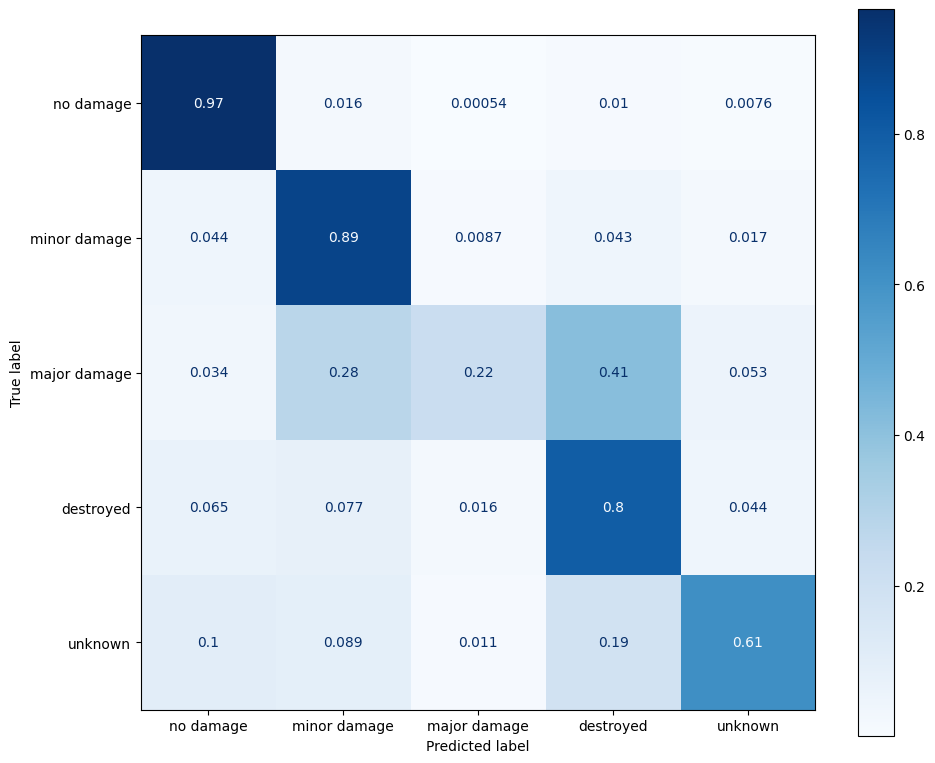

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = ["no damage", "minor damage", "major damage", "destroyed", "unknown"]

cm = confusion_matrix(val_labels, val_preds, labels=list(range(len(labels))), normalize='true')

fig, ax = plt.subplots(figsize=(10, 8))  # <-- increase figure size here
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

model.eval()

all_paths = []
all_labels = []
all_probs = []
all_preds = []
all_is_post = []

threshold = 0.5  # tune later

for idx in tqdm(range(len(full_dataset)), desc="Batch inference"):
    img, label = full_dataset[idx]  # img is already transformed
    tile_path = full_dataset.img_paths[idx]
    is_post = 1 if "post_disaster" in os.path.basename(tile_path) else 0

    x = img.unsqueeze(0).to(device)
    label = label.item()

    with torch.no_grad():
        logit = model(x)
        prob = torch.sigmoid(logit).item()
        pred = 1 if prob > threshold else 0

    all_paths.append(tile_path)
    all_labels.append(label)
    all_probs.append(prob)
    all_preds.append(pred)
    all_is_post.append(is_post)

len(all_paths)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78d05d04e2a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1618, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 1136, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
    

Batch inference:   0%|          | 0/50382 [00:00<?, ?it/s]

50382

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = np.array(all_labels, dtype=int)
y_pred = np.array(all_preds, dtype=int)


In [ ]:
pred_df = pd.DataFrame({
    "tile_path": all_paths,
    "true_label": all_labels,
    "prob_building": all_probs,
    "pred_label": all_preds,
    "is_post_disaster": all_is_post,
})

pred_csv_path = os.path.join(PROCESSED_DIR, "binary_building_predictions.csv")
pred_df.to_csv(pred_csv_path, index=False)

pred_df.head(), pred_csv_path


(                                           tile_path  true_label  \
 0  /content/dataset/images/guatemala-volcano_0000...         1.0   
 1  /content/dataset/images/guatemala-volcano_0000...         1.0   
 2  /content/dataset/images/guatemala-volcano_0000...         1.0   
 3  /content/dataset/images/guatemala-volcano_0000...         1.0   
 4  /content/dataset/images/guatemala-volcano_0000...         1.0   
 
    prob_building  pred_label  is_post_disaster  
 0       0.999767           1                 1  
 1       0.986553           1                 1  
 2       0.981644           1                 1  
 3       0.998263           1                 1  
 4       0.942191           1                 1  ,
 '/content/dataset/binary_building_predictions.csv')

In [ ]:
import os
import shutil
import pandas as pd

BUILDING_TILE_DIR = "/content/building_tiles_for_damage_classifier"
IMGS_OUT = os.path.join(BUILDING_TILE_DIR, "images")
MASKS_OUT = os.path.join(BUILDING_TILE_DIR, "masks")

os.makedirs(IMGS_OUT, exist_ok=True)
os.makedirs(MASKS_OUT, exist_ok=True)

MASK_DIR = os.path.join(PROCESSED_DIR, "masks")

filter_threshold = 0.5  # or use tuned threshold if you did that

export_records = []

for path, prob, is_post in zip(all_paths, all_probs, all_is_post):
    # keep only tiles that are:
    #   - predicted to contain buildings
    #   - post-disaster
    if prob > filter_threshold and is_post == 1:
        filename = os.path.basename(path)

        # copy image
        dest_img = os.path.join(IMGS_OUT, filename)
        shutil.copy2(path, dest_img)

        # copy mask (if it exists)
        src_mask = os.path.join(MASK_DIR, filename)
        if os.path.exists(src_mask):
            dest_mask = os.path.join(MASKS_OUT, filename)
            shutil.copy2(src_mask, dest_mask)

        export_records.append([filename, path, prob])

len(export_records), BUILDING_TILE_DIR



(15760, '/content/building_tiles_for_damage_classifier')

In [ ]:
export_df = pd.DataFrame(
    export_records,
    columns=["filename", "orig_path", "building_prob"]
)

export_csv = os.path.join(BUILDING_TILE_DIR, "building_tiles_post_only.csv")
export_df.to_csv(export_csv, index=False)

print("Export complete!")
print(f"Images: {IMGS_OUT}")
print(f"Masks: {MASKS_OUT}")
print(f"Metadata CSV: {export_csv}")
print(f"Total tiles forwarded to damage classifier: {len(export_records)}")


Export complete!
Images: /content/building_tiles_for_damage_classifier/images
Masks: /content/building_tiles_for_damage_classifier/masks
Metadata CSV: /content/building_tiles_for_damage_classifier/building_tiles_post_only.csv
Total tiles forwarded to damage classifier: 15760


In [ ]:
import os
import shutil
import pandas as pd

EXPORT_DIR = "/content/damage_classifier_input"

PRE_IMG_DIR = os.path.join(EXPORT_DIR, "pre_images")
POST_IMG_DIR = os.path.join(EXPORT_DIR, "post_images")
PRE_MASK_DIR = os.path.join(EXPORT_DIR, "pre_masks")
POST_MASK_DIR = os.path.join(EXPORT_DIR, "post_masks")

os.makedirs(PRE_IMG_DIR, exist_ok=True)
os.makedirs(POST_IMG_DIR, exist_ok=True)
os.makedirs(PRE_MASK_DIR, exist_ok=True)
os.makedirs(POST_MASK_DIR, exist_ok=True)

IMG_DIR = os.path.join(PROCESSED_DIR, "images")
MASK_DIR = os.path.join(PROCESSED_DIR, "masks")

filter_threshold = 0.5

paired_records = []

for path, prob, is_post in zip(all_paths, all_probs, all_is_post):
    # 1) we only care about post-disaster tiles that have buildings
    if is_post != 1:
        continue
    if prob <= filter_threshold:
        continue

    post_img_path = path
    fname_post = os.path.basename(post_img_path)

    # 2) derive matching pre-disaster filename for the same tile
    #    e.g. "xxx_post_disaster_tile_0.png" -> "xxx_pre_disaster_tile_0.png"
    if "post_disaster" not in fname_post:
        continue

    fname_pre = fname_post.replace("post_disaster", "pre_disaster")
    pre_img_path = os.path.join(IMG_DIR, fname_pre)

    if not os.path.exists(pre_img_path):
        # no matching pre tile for this post tile → skip
        continue

    # 3) copy images to export dirs
    dst_post_img = os.path.join(POST_IMG_DIR, fname_post)
    dst_pre_img = os.path.join(PRE_IMG_DIR, fname_pre)
    shutil.copy2(post_img_path, dst_post_img)
    shutil.copy2(pre_img_path, dst_pre_img)

    # 4) copy masks if they exist
    post_mask_src = os.path.join(MASK_DIR, fname_post)
    pre_mask_src = os.path.join(MASK_DIR, fname_pre)

    dst_post_mask = None
    dst_pre_mask = None

    if os.path.exists(post_mask_src):
        dst_post_mask = os.path.join(POST_MASK_DIR, fname_post)
        shutil.copy2(post_mask_src, dst_post_mask)

    if os.path.exists(pre_mask_src):
        dst_pre_mask = os.path.join(PRE_MASK_DIR, fname_pre)
        shutil.copy2(pre_mask_src, dst_pre_mask)

    # 5) record this pair for the CSV
    paired_records.append({
        "pre_image": dst_pre_img,
        "post_image": dst_post_img,
        "pre_mask": dst_pre_mask,
        "post_mask": dst_post_mask,
        "building_prob_post": prob,
    })

len(paired_records), EXPORT_DIR


(15760, '/content/damage_classifier_input')

In [ ]:
pairs_df = pd.DataFrame(paired_records)
csv_path = os.path.join(EXPORT_DIR, "paired_building_tiles.csv")
pairs_df.to_csv(csv_path, index=False)

print("Saved paired tiles CSV to:", csv_path)
pairs_df.head()


Saved paired tiles CSV to: /content/damage_classifier_input/paired_building_tiles.csv


,pre_image,post_image,pre_mask,post_mask,building_prob_post
0,/content/damage_classifier_input/pre_images/gu...,/content/damage_classifier_input/post_images/g...,/content/damage_classifier_input/pre_masks/gua...,/content/damage_classifier_input/post_masks/gu...,0.999767
1,/content/damage_classifier_input/pre_images/gu...,/content/damage_classifier_input/post_images/g...,/content/damage_classifier_input/pre_masks/gua...,/content/damage_classifier_input/post_masks/gu...,0.986553
2,/content/damage_classifier_input/pre_images/gu...,/content/damage_classifier_input/post_images/g...,/content/damage_classifier_input/pre_masks/gua...,/content/damage_classifier_input/post_masks/gu...,0.981644
3,/content/damage_classifier_input/pre_images/gu...,/content/damage_classifier_input/post_images/g...,/content/damage_classifier_input/pre_masks/gua...,/content/damage_classifier_input/post_masks/gu...,0.998263
4,/content/damage_classifier_input/pre_images/gu...,/content/damage_classifier_input/post_images/g...,/content/damage_classifier_input/pre_masks/gua...,/content/damage_classifier_input/post_masks/gu...,0.942191


In [ ]:
!zip -r damage_classifier_input.zip /content/damage_classifier_input
!mv damage_classifier_input.zip "/content/drive/MyDrive/CAIS++ Mini Project + Final Project/"
# to unzip later do:
#!unzip "damage_classifier_input.zip" -d "./damage_classifier_input"


Streaming output truncated to the last 5000 lines.
  adding: content/damage_classifier_input/pre_images/santa-rosa-wildfire_00000151_pre_disaster_tile_5.png (deflated 2%)
  adding: content/damage_classifier_input/pre_images/socal-fire_00001359_pre_disaster_tile_7.png (deflated 2%)
  adding: content/damage_classifier_input/pre_images/hurricane-michael_00000269_pre_disaster_tile_4.png (deflated 5%)
  adding: content/damage_classifier_input/pre_images/hurricane-florence_00000355_pre_disaster_tile_3.png (deflated 2%)
  adding: content/damage_classifier_input/pre_images/hurricane-harvey_00000379_pre_disaster_tile_2.png (deflated 1%)
  adding: content/damage_classifier_input/pre_images/hurricane-michael_00000511_pre_disaster_tile_0.png (deflated 2%)
  adding: content/damage_classifier_input/pre_images/santa-rosa-wildfire_00000373_pre_disaster_tile_8.png (deflated 2%)
  adding: content/damage_classifier_input/pre_images/midwest-flooding_00000273_pre_disaster_tile_8.png (deflated 3%)
  adding:

## Extract Test Data

Unzipping the test dataset from Google Drive to a local directory for faster access.

In [ ]:
import os
import shutil

# Define Paths for Test Data
ZIP_TEST_SOURCE = "/content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/test/processed_data_test/processed_binary_test.zip"
EXTRACT_TEST_DEST = "/content/test_dataset"

# Copy & Unzip Test Data
if not os.path.exists(EXTRACT_TEST_DEST):
    print("Copying test zip from Drive...")
    shutil.copy(ZIP_TEST_SOURCE, "/content/temp_test_data.zip")

    print("Unzipping test data...")
    shutil.unpack_archive("/content/temp_test_data.zip", EXTRACT_TEST_DEST)

    # Cleanup
    os.remove("/content/temp_test_data.zip")
    print(f"Test data ready at {EXTRACT_TEST_DEST}")
else:
    print("Test data already extracted!")

Copying test zip from Drive...
Unzipping test data...
Test data ready at /content/test_dataset


In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# i took same BinaryBuildingDataset class and transform from training setup
test_dataset = BinaryBuildingDataset(EXTRACT_TEST_DEST, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Test dataset size: {len(test_dataset)}")

model.eval()

test_probs = []
test_labels = []
test_preds = []

threshold = 0.5

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Test Inference"):
        imgs = imgs.to(device)

        logits = model(imgs)
        probs = torch.sigmoid(logits)
        preds = (probs > threshold).float()

        test_probs.extend(probs.cpu().numpy().tolist())
        test_labels.extend(labels.numpy().tolist())
        test_preds.extend(preds.cpu().numpy().tolist())

# store paths for filtering later
test_paths = test_dataset.img_paths

print("Inference complete.")

Test dataset size: 16794


Test Inference:   0%|          | 0/525 [00:00<?, ?it/s]

Inference complete.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_test_true = np.array(test_labels, dtype=int)
y_test_pred = np.array(test_preds, dtype=int)

print("Confusion Matrix (rows=true, cols=pred):")
print(confusion_matrix(y_test_true, y_test_pred))

print("\nClassification Report:")
print(classification_report(y_test_true, y_test_pred,
                            target_names=["no_buildings", "has_buildings"]))


Confusion Matrix (rows=true, cols=pred):
[[6223  365]
 [ 808 9398]]

Classification Report:
               precision    recall  f1-score   support

 no_buildings       0.89      0.94      0.91      6588
has_buildings       0.96      0.92      0.94     10206

     accuracy                           0.93     16794
    macro avg       0.92      0.93      0.93     16794
 weighted avg       0.93      0.93      0.93     16794



## Filter and Pair Test Data

We now identify post-disaster tiles from the test set that are predicted to contain buildings (probability > 0.5). For each valid post-tile, we find its matching pre-disaster tile and copy both (along with masks) to a clean export directory.

In [ ]:
import os
import shutil
import pandas as pd

# 1. Setup Export Directory
EXPORT_TEST_DIR = "/content/damage_classifier_test_input"

PRE_IMG_DIR = os.path.join(EXPORT_TEST_DIR, "pre_images")
POST_IMG_DIR = os.path.join(EXPORT_TEST_DIR, "post_images")
PRE_MASK_DIR = os.path.join(EXPORT_TEST_DIR, "pre_masks")
POST_MASK_DIR = os.path.join(EXPORT_TEST_DIR, "post_masks")

os.makedirs(PRE_IMG_DIR, exist_ok=True)
os.makedirs(POST_IMG_DIR, exist_ok=True)
os.makedirs(PRE_MASK_DIR, exist_ok=True)
os.makedirs(POST_MASK_DIR, exist_ok=True)

# Source Directories from Test Set
TEST_IMG_DIR = os.path.join(EXTRACT_TEST_DEST, "images")
TEST_MASK_DIR = os.path.join(EXTRACT_TEST_DEST, "masks")

filter_threshold = 0.5
paired_test_records = []

# 2. Iterate and Filter
for path, prob in zip(test_paths, test_probs):
    fname_post = os.path.basename(path)

    # Check if it's a post-disaster tile
    if "post_disaster" not in fname_post:
        continue

    # Check if probability exceeds threshold
    if prob <= filter_threshold:
        continue

    # 3. Find Matching Pre-Disaster Tile
    fname_pre = fname_post.replace("post_disaster", "pre_disaster")
    pre_img_path = os.path.join(TEST_IMG_DIR, fname_pre)

    if not os.path.exists(pre_img_path):
        # Skip if no matching pre tile exists
        continue

    # 4. Copy Images
    dst_post_img = os.path.join(POST_IMG_DIR, fname_post)
    dst_pre_img = os.path.join(PRE_IMG_DIR, fname_pre)
    shutil.copy2(path, dst_post_img)
    shutil.copy2(pre_img_path, dst_pre_img)

    # 5. Copy Masks (if they exist)
    post_mask_src = os.path.join(TEST_MASK_DIR, fname_post)
    pre_mask_src = os.path.join(TEST_MASK_DIR, fname_pre)

    dst_post_mask = None
    dst_pre_mask = None

    if os.path.exists(post_mask_src):
        dst_post_mask = os.path.join(POST_MASK_DIR, fname_post)
        shutil.copy2(post_mask_src, dst_post_mask)

    if os.path.exists(pre_mask_src):
        dst_pre_mask = os.path.join(PRE_MASK_DIR, fname_pre)
        shutil.copy2(pre_mask_src, dst_pre_mask)

    # 6. Record Metadata
    paired_test_records.append({
        "pre_image": dst_pre_img,
        "post_image": dst_post_img,
        "pre_mask": dst_pre_mask,
        "post_mask": dst_post_mask,
        "building_prob_post": prob,
    })

print(f"Processing complete. Found {len(paired_test_records)} valid pre/post pairs in test set.")

Processing complete. Found 4857 valid pre/post pairs in test set.


In [ ]:
# Save Metadata CSV
test_pairs_df = pd.DataFrame(paired_test_records)
csv_path = os.path.join(EXPORT_TEST_DIR, "paired_test_building_tiles.csv")
test_pairs_df.to_csv(csv_path, index=False)

print("Saved paired test tiles CSV to:", csv_path)
test_pairs_df.head()

Saved paired test tiles CSV to: /content/damage_classifier_test_input/paired_test_building_tiles.csv


,pre_image,post_image,pre_mask,post_mask,building_prob_post
0,/content/damage_classifier_test_input/pre_imag...,/content/damage_classifier_test_input/post_ima...,/content/damage_classifier_test_input/pre_mask...,/content/damage_classifier_test_input/post_mas...,0.999685
1,/content/damage_classifier_test_input/pre_imag...,/content/damage_classifier_test_input/post_ima...,/content/damage_classifier_test_input/pre_mask...,/content/damage_classifier_test_input/post_mas...,1.000000
2,/content/damage_classifier_test_input/pre_imag...,/content/damage_classifier_test_input/post_ima...,/content/damage_classifier_test_input/pre_mask...,/content/damage_classifier_test_input/post_mas...,1.000000
3,/content/damage_classifier_test_input/pre_imag...,/content/damage_classifier_test_input/post_ima...,/content/damage_classifier_test_input/pre_mask...,/content/damage_classifier_test_input/post_mas...,0.999987
4,/content/damage_classifier_test_input/pre_imag...,/content/damage_classifier_test_input/post_ima...,/content/damage_classifier_test_input/pre_mask...,/content/damage_classifier_test_input/post_mas...,0.999999


In [ ]:
# Zip and Move to Drive
!zip -r damage_classifier_test_input.zip /content/damage_classifier_test_input
!mv damage_classifier_test_input.zip "/content/drive/MyDrive/CAIS++ Mini Project + Final Project/"

print("\nExport complete! 'damage_classifier_test_input.zip' has been saved to your Drive.")

  adding: content/damage_classifier_test_input/ (stored 0%)
  adding: content/damage_classifier_test_input/post_masks/ (stored 0%)
  adding: content/damage_classifier_test_input/post_masks/hurricane-harvey_00000033_post_disaster_tile_4.png (deflated 23%)
  adding: content/damage_classifier_test_input/post_masks/socal-fire_00000815_post_disaster_tile_3.png (deflated 39%)
  adding: content/damage_classifier_test_input/post_masks/socal-fire_00000815_post_disaster_tile_6.png (deflated 37%)
  adding: content/damage_classifier_test_input/post_masks/midwest-flooding_00000396_post_disaster_tile_2.png (deflated 66%)
  adding: content/damage_classifier_test_input/post_masks/hurricane-florence_00000286_post_disaster_tile_6.png (deflated 27%)
  adding: content/damage_classifier_test_input/post_masks/hurricane-michael_00000176_post_disaster_tile_7.png (deflated 55%)
  adding: content/damage_classifier_test_input/post_masks/midwest-flooding_00000128_post_disaster_tile_3.png (deflated 85%)
  adding: 

get max damage classifier
